In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import os
import argparse


def update_ema(ema_model, model, ema_rate):
    for tar, src in zip(ema_model.parameters(), model.parameters()):
        tar.data.mul_(ema_rate).add_(src.data * (1 - ema_rate))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [2]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [3]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, init_scale=1., learnable=False):
        super().__init__()
        self.emb = init_scale * torch.randn(embed_dim // 2)
        self.emb = nn.Parameter(self.emb, requires_grad=learnable)
    
    def forward(self, t):
        t = 2. * np.pi * t[:, None] * self.emb[None, :]
        return torch.cat([torch.sin(t), torch.cos(t)], dim=-1)


class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, max_positions=10000):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_positions = max_positions 
        self.half_dim = embed_dim // 2
        self.emb = math.log(max_positions) / (self.half_dim - 1)
        self.emb = torch.exp(torch.arange(self.half_dim).float() * -self.emb)
        self.emb = nn.Parameter(self.emb, requires_grad=False)

    def forward(self, t):
        t = 0.9 * self.max_positions * t[:, None] * self.emb[None, :]
        return torch.cat([torch.sin(t), torch.cos(t)], dim=-1)



In [4]:
class Upsize(nn.Module):
    def __init__(self, cin, cout=None):
        super().__init__()
        cout = cin if cout is None else cout
        self.conv = nn.Conv2d(cin, cout, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        x = self.conv(x)
        return x


class Downsize(nn.Module):
    def __init__(self, cin, cout=None):
        super().__init__()
        cout = cin if cout is None else cout
        self.conv = nn.Conv2d(cin, cout, 3, 2, 0)

    def forward(self, x):
        x = F.pad(x, (0, 1, 0, 1), mode="constant", value=0)
        x = self.conv(x)
        return x

In [5]:
def get_signal_scale(log_snr):
    return torch.sigmoid(log_snr).sqrt()

def get_noise_scale(log_snr):
    return torch.sigmoid(-log_snr).sqrt()


class LinearLogSnrDiffuser(object):
    def __init__(self):
        self.min_time = 1e-5
        self.log_snr0 = np.log(1 / (np.exp(1e-4) - 1))
        self.log_snr1 = np.log(1 / (np.exp(1e-4 + 10) - 1))

    def sample_time(self, batch_size):
        return self.min_time + torch.rand(batch_size) * (1. - self.min_time)

    def log_snr(self, t):
        return self.log_snr0 + (self.log_snr1 - self.log_snr0) * t
    
    def forward_process(self, x, t, noise=None):
        noise = torch.randn_like(x) if noise is None else noise
        log_snr = self.log_snr(t).unflatten(-1, (-1, *[1 for _ in x.size()[1:]]))
        alpha = get_signal_scale(log_snr)
        sigma = get_noise_scale(log_snr)
        return alpha * x + sigma * noise, noise

    @torch.no_grad()
    def reverse_process(self, z, model, num_steps):
        time = torch.ones(z.size()[0]).to(z.device)
        reversed_time = torch.linspace(1., 0., num_steps + 1)
        dt = reversed_time[0] - reversed_time[1]
        for i in range(num_steps): # t -> s
            t = reversed_time[i]        
            s = reversed_time[i + 1]
            log_snr_s = self.log_snr(s)
            log_snr_t = self.log_snr(t)
            alpha_s = get_signal_scale(log_snr_s)
            sigma_s = get_noise_scale(log_snr_s)
            alpha_t = get_signal_scale(log_snr_t)
            sigma_t = get_noise_scale(log_snr_t)
            alpha_s_to_t = alpha_t / alpha_s
            sigma_s_to_t = torch.sqrt(sigma_t.square() - alpha_s_to_t.square() * sigma_s.square())
            sigma_t_to_s = torch.sqrt(sigma_s.square() * sigma_s_to_t.square() / sigma_t.square())
            prev_coeff = 1 / alpha_s_to_t
            noise_coeff = - sigma_s_to_t.square() / (alpha_s_to_t * sigma_t)

            time.fill_(t)
            noise_pred = model(z, time)
            z = prev_coeff * z + noise_coeff * noise_pred + torch.randn_like(z) * sigma_t_to_s
            x_pred = (z - sigma_s * noise_pred) / alpha_s

        return x_pred


In [6]:
class Resnet(nn.Module):
    def __init__(self, in_ch, out_ch, num_groups=8, time_dim=None, dropout_ratio=0.05, bottleneck_ratio=0.5):
        super().__init__()
        cmid = int(bottleneck_ratio * in_ch)
        self.res_in = nn.Sequential(nn.GroupNorm(num_groups, in_ch),
                                    nn.SiLU(inplace=True),
                                    nn.Conv2d(in_ch, cmid, 3, 1, 1))

        self.time = nn.Linear(time_dim, cmid) if time_dim is not None else None

        self.res_out = nn.Sequential(nn.GroupNorm(num_groups, num_channels=cmid),
                                     nn.SiLU(inplace=True),
                                     nn.Dropout(p=dropout_ratio),
                                     nn.Conv2d(cmid, out_ch, 3, 1, 1))

        self.skip = None if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1, 1, 0)

    def forward(self, x, t=None):
        res = self.res_in(x)
        if t is not None:
            time = self.time(t).unflatten(-1, (-1, 1, 1))
            res = res + time
        
        res = self.res_out(res)
        return x + res if self.skip is None else self.skip(x) + res


In [7]:
# class Attention(nn.Module):
#     def __init__(self, channels, num_groups=8):
#         super().__init__()
#         self.group_norm = nn.GroupNorm(num_groups, channels)
#         self.proj = nn.Conv2d(channels, 3 * channels, 1, 1, 0, bias=False)
#         self.out = nn.Conv2d(channels, channels, 1, 1, 0)
#         self.scale = self.channels ** -0.5

#     def forward(self, x):
#         h = self.group_norm(x)
#         q, k, v = self.proj(h).flatten(-2, -1).chunk(3, dim=1)        
#         w = torch.bmm(q.transpose(-2, -1), k * self.scale)
#         h = torch.bmm(v, w.softmax(dim=1)).unflatten(-1, x.size()[2:])
#         return x + self.out(h)


class Attention(nn.Module):
    def __init__(self, channels, num_heads=4, num_groups=8, bottleneck_ratio=0.5):
        super().__init__()
        self.hidden_size = int(bottleneck_ratio * channels)
        self.channels, self.num_heads = channels, num_heads
        self.group_norm = nn.GroupNorm(num_groups, channels)
        self.proj = nn.Conv2d(channels, 3 * self.hidden_size, 1, 1, 0, bias=False)
        self.out = nn.Conv2d(self.hidden_size, channels, 1, 1, 0)
        self.scale = (self.hidden_size // self.num_heads) ** -0.5

    def forward(self, x):
        h = self.group_norm(x)
        q, k, v = self.proj(h).flatten(-2, -1).unflatten(1, (self.num_heads * 3, -1)).chunk(3, dim=1)
        w = torch.matmul(q.transpose(-2, -1), k * self.scale)
        h = torch.matmul(v, w.softmax(dim=-2)).unflatten(-1, x.size()[2:]).flatten(1, 2)
        return x + self.out(h)

In [8]:
class UNet(nn.Module):
    def __init__(self, args):
        super().__init__()

        self.channels = args.arch.channels
        self.time_dim = args.arch.time_dim

        self.input_conv = [nn.Conv2d(args.arch.input_channels, self.channels, 3, 1, padding='same'),
                           nn.SiLU()]

        self.input_conv = nn.Sequential(*self.input_conv)
        
        self.time_embed = [PositionalEmbedding(self.channels),
                           nn.Linear(self.channels, self.time_dim), 
                           nn.SiLU(inplace=True), 
                           nn.Linear(self.time_dim, self.time_dim),
                           nn.SiLU()]

        self.time_embed = nn.Sequential(*self.time_embed)

        self.enc_tower = []

        for l, n_layers in enumerate(args.arch.n_layers):
            in_ch = self.channels if l == 0 else args.arch.ch_mults[l - 1] * self.channels
            ch = args.arch.ch_mults[l] * self.channels
            block = Downsize(in_ch, ch) if args.arch.resample[l] else nn.Conv2d(in_ch, ch, 1, 1, 0)
            self.enc_tower += [block]

            for _ in range(n_layers):
                self.enc_tower += [Resnet(ch, ch, time_dim=self.time_dim)]
                self.enc_tower += [Attention(ch)] if args.arch.use_attn[l] else []

        self.enc_tower = nn.ModuleList(self.enc_tower)
        mid_ch = args.arch.ch_mults[-1] * self.channels
        self.mid1 = Resnet(mid_ch, mid_ch, time_dim=self.time_dim)
        self.mid2 = Attention(mid_ch, bottleneck_ratio=0.25)
        self.mid3 = Resnet(mid_ch, mid_ch, time_dim=self.time_dim)

        self.dec_tower = []
        for l, mult in list(enumerate(args.arch.n_layers))[::-1]:
            
            ch = args.arch.ch_mults[l] * self.channels
            out_ch = self.channels if l == 0 else args.arch.ch_mults[l - 1] * self.channels

            for _ in range(n_layers):
                self.dec_tower += [Attention(ch)] if args.arch.use_attn[l] else []
                self.dec_tower += [Resnet(2 * ch, ch, time_dim=self.time_dim)]

            block = Upsize(ch, out_ch) if args.arch.resample[l] else nn.Conv2d(ch, out_ch, 1, 1, 0)
            self.dec_tower += [block]
        
        self.dec_tower = nn.ModuleList(self.dec_tower)
        self.output_conv = [nn.SiLU(),
                            nn.Conv2d(self.channels, args.arch.output_channels, 1, 1, 0)]

        self.output_conv = nn.Sequential(*self.output_conv)


    def forward(self, x, t):
        x = self.input_conv(x)
        t = self.time_embed(t)
        u = []
        for enc in self.enc_tower:
            if isinstance(enc, Resnet):
                x = enc(x, t)
                u.append(x)
            else:
                x = enc(x)

        x = self.mid1(x, t)
        x = self.mid2(x)
        x = self.mid3(x, t)

        for dec in self.dec_tower:
            if isinstance(dec, Resnet):
                x = torch.cat([x, u.pop()], dim=1)
                x = dec(x, t)
            else:
                x = dec(x)

        x = self.output_conv(x)
        return x



In [9]:
args = argparse.Namespace()
args.arch = argparse.Namespace()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 64
args.learning_rate = 1e-4
args.num_epochs = 100
args.ema_rate = 0.9999

args.arch.input_channels = 3
args.arch.output_channels = 3
args.arch.channels = 128
args.arch.time_dim = args.arch.channels * 4
args.arch.ch_mults = [1, 2, 4, 8]
args.arch.n_layers = [4, 4, 4, 4]
args.arch.use_attn = [False, False,  True, False]
args.arch.resample = [False,  True,  True,  True]

model = UNet(args).to(args.device)
ema_model = copy.deepcopy(model)

ema_model.requires_grad_(False)
diffuser = LinearLogSnrDiffuser()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
loss_meter = AverageMeter()

In [10]:
!nvidia-smi

Thu Jul  7 18:33:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    37W / 250W |   2883MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
state_dict = torch.load("/content/drive/My Drive/" + "vdm_cifar10.pth")
model.load_state_dict(state_dict['model'])
optimizer.load_state_dict(state_dict['optimizer'])
ema_model.load_state_dict(state_dict['ema_model'])

<All keys matched successfully>

In [ ]:
loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)


for epoch in range(200):
    loss_meter.reset()
    for x, _ in loader:
        x = x.to(args.device)
        x = 2. * x - 1.
        t = diffuser.sample_time(x.size()[0]).to(args.device)
        optimizer.zero_grad()
        z, noise = diffuser.forward_process(x, t)
        noise_pred = model(z, t)
        loss = (noise - noise_pred).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        update_ema(ema_model, model, args.ema_rate)

    print('[epoch %3d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))

[epoch   0] | loss: 570.32570 |
[epoch   1] | loss: 425.10506 |
[epoch   2] | loss: 406.68303 |
[epoch   3] | loss: 393.63393 |
[epoch   4] | loss: 387.68792 |
[epoch   5] | loss: 383.26302 |
[epoch   6] | loss: 380.30523 |
[epoch   7] | loss: 380.16518 |
[epoch   8] | loss: 374.12935 |
[epoch   9] | loss: 373.59918 |
[epoch  10] | loss: 369.12057 |
[epoch  11] | loss: 370.00153 |
[epoch  12] | loss: 370.70745 |
[epoch  13] | loss: 367.91613 |
[epoch  14] | loss: 365.69335 |
[epoch  15] | loss: 367.18137 |
[epoch  16] | loss: 365.19603 |
[epoch  17] | loss: 362.46564 |
[epoch  18] | loss: 363.59222 |
[epoch  19] | loss: 362.48527 |
[epoch  20] | loss: 361.58066 |
[epoch  21] | loss: 362.03105 |
[epoch  22] | loss: 356.29735 |
[epoch  23] | loss: 357.90883 |
[epoch  24] | loss: 357.75124 |
[epoch  25] | loss: 358.69972 |
[epoch  26] | loss: 354.47037 |
[epoch  27] | loss: 354.68563 |
[epoch  28] | loss: 353.13022 |
[epoch  29] | loss: 358.40759 |
[epoch  30] | loss: 352.73467 |
[epoch  

KeyboardInterrupt: ignored

In [ ]:
loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)


for epoch in range(200):
    loss_meter.reset()
    for x, _ in loader:
        x = x.to(args.device)
        x = 2. * x - 1.
        t = diffuser.sample_time(x.size()[0]).to(args.device)
        optimizer.zero_grad()
        z, noise = diffuser.forward_process(x, t)
        noise_pred = model(z, t)
        loss = (noise - noise_pred).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        update_ema(ema_model, model, args.ema_rate)

    print('[epoch %3d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))

[epoch   0] | loss: 338.21817 |
[epoch   1] | loss: 341.36959 |
[epoch   2] | loss: 343.67202 |
[epoch   3] | loss: 343.14879 |
[epoch   4] | loss: 340.38420 |
[epoch   5] | loss: 334.95020 |
[epoch   6] | loss: 340.50038 |
[epoch   7] | loss: 339.95899 |
[epoch   8] | loss: 337.59122 |
[epoch   9] | loss: 335.96820 |
[epoch  10] | loss: 337.84178 |
[epoch  11] | loss: 336.66301 |
[epoch  12] | loss: 337.72631 |
[epoch  13] | loss: 339.77901 |
[epoch  14] | loss: 336.74426 |
[epoch  15] | loss: 340.95226 |
[epoch  16] | loss: 340.35421 |
[epoch  17] | loss: 334.91266 |
[epoch  18] | loss: 337.59079 |
[epoch  19] | loss: 337.87605 |
[epoch  20] | loss: 337.54535 |
[epoch  21] | loss: 337.71423 |
[epoch  22] | loss: 335.22647 |
[epoch  23] | loss: 337.45976 |
[epoch  24] | loss: 337.80770 |
[epoch  25] | loss: 339.10532 |
[epoch  26] | loss: 334.16626 |
[epoch  27] | loss: 338.26742 |
[epoch  28] | loss: 336.84903 |
[epoch  29] | loss: 339.87304 |
[epoch  30] | loss: 337.24637 |
[epoch  

KeyboardInterrupt: ignored

In [15]:
loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)


for epoch in range(200):
    loss_meter.reset()
    for x, _ in loader:
        x = x.to(args.device)
        x = 2. * x - 1.
        t = diffuser.sample_time(x.size()[0]).to(args.device)
        optimizer.zero_grad()
        z, noise = diffuser.forward_process(x, t)
        noise_pred = model(z, t)
        loss = (noise - noise_pred).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        update_ema(ema_model, model, args.ema_rate)

    print('[epoch %3d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))

[epoch   0] | loss: 340.60329 |
[epoch   1] | loss: 331.90945 |
[epoch   2] | loss: 335.11204 |
[epoch   3] | loss: 340.14493 |
[epoch   4] | loss: 337.51395 |
[epoch   5] | loss: 338.09575 |
[epoch   6] | loss: 334.38783 |
[epoch   7] | loss: 335.98492 |
[epoch   8] | loss: 336.99613 |
[epoch   9] | loss: 333.28994 |
[epoch  10] | loss: 335.24001 |
[epoch  11] | loss: 336.88325 |
[epoch  12] | loss: 336.18641 |
[epoch  13] | loss: 336.42518 |
[epoch  14] | loss: 334.41633 |
[epoch  15] | loss: 335.69681 |
[epoch  16] | loss: 335.07377 |
[epoch  17] | loss: 334.16931 |
[epoch  18] | loss: 334.87114 |
[epoch  19] | loss: 332.14421 |
[epoch  20] | loss: 334.96175 |
[epoch  21] | loss: 335.71844 |
[epoch  22] | loss: 336.91973 |
[epoch  23] | loss: 332.54611 |
[epoch  24] | loss: 336.52023 |
[epoch  25] | loss: 333.91987 |
[epoch  26] | loss: 333.07151 |
[epoch  27] | loss: 335.38554 |
[epoch  28] | loss: 331.87653 |
[epoch  29] | loss: 334.59074 |
[epoch  30] | loss: 333.70878 |
[epoch  

KeyboardInterrupt: ignored

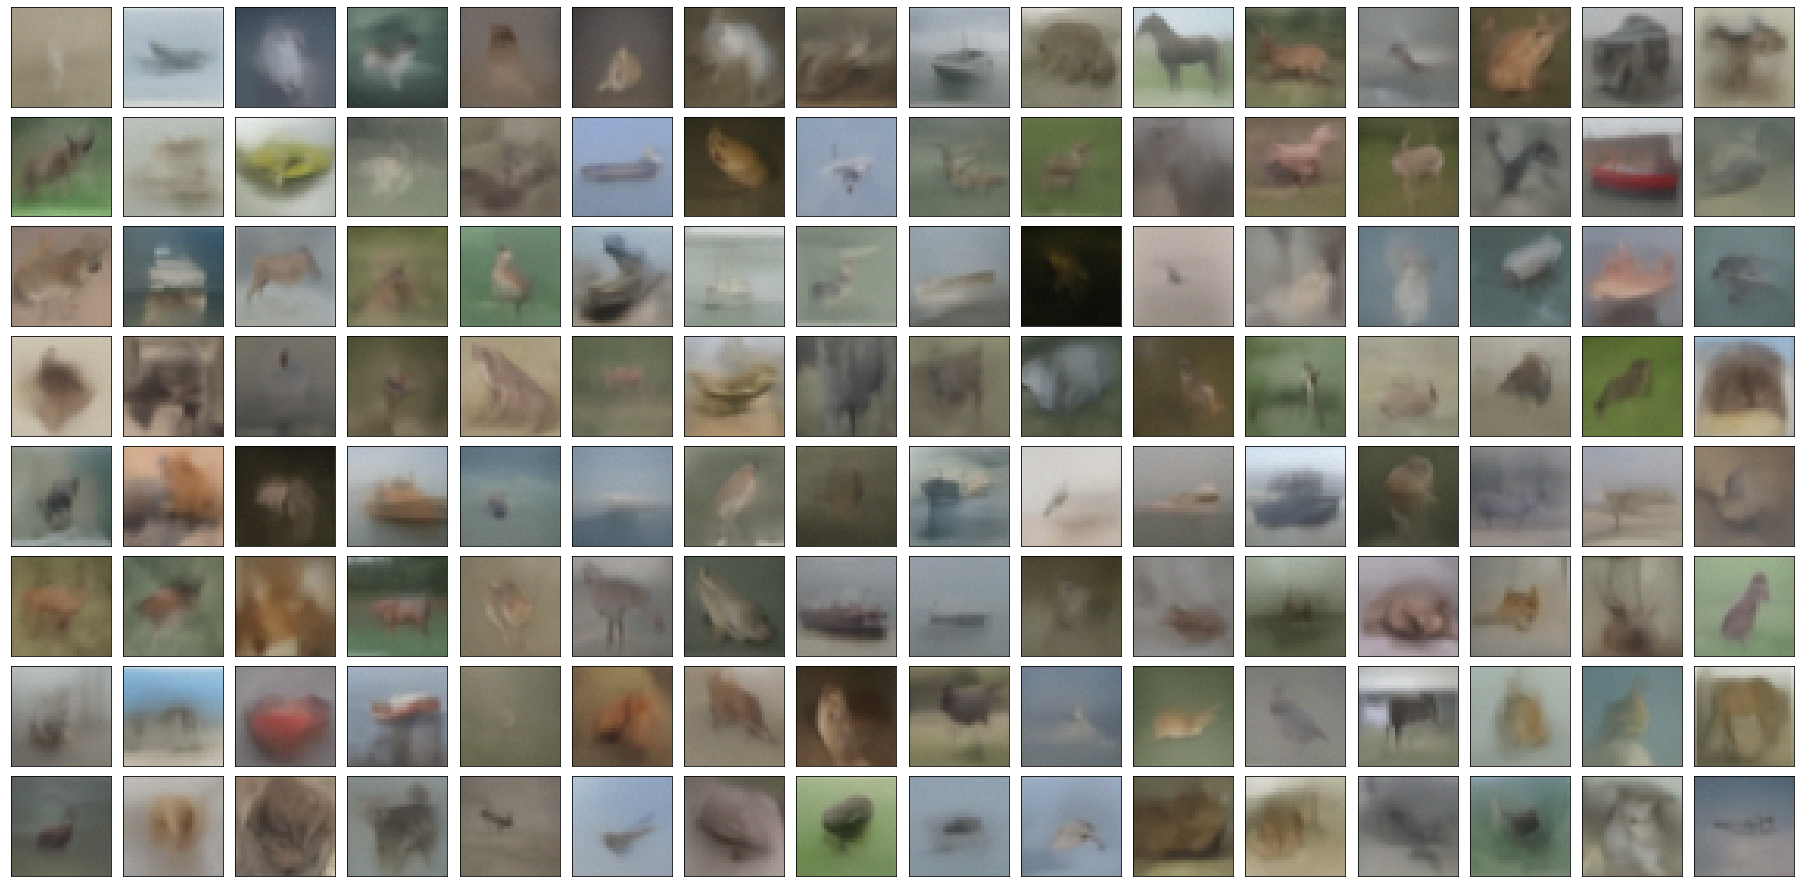

In [20]:
z = torch.randn(128, 3, 32, 32).to(args.device)
z = diffuser.reverse_process(z, ema_model, num_steps=5)

out = z.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

n = 0

for i in range(8 *  16):
    _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
    _fig.imshow(out[i])
    n += 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

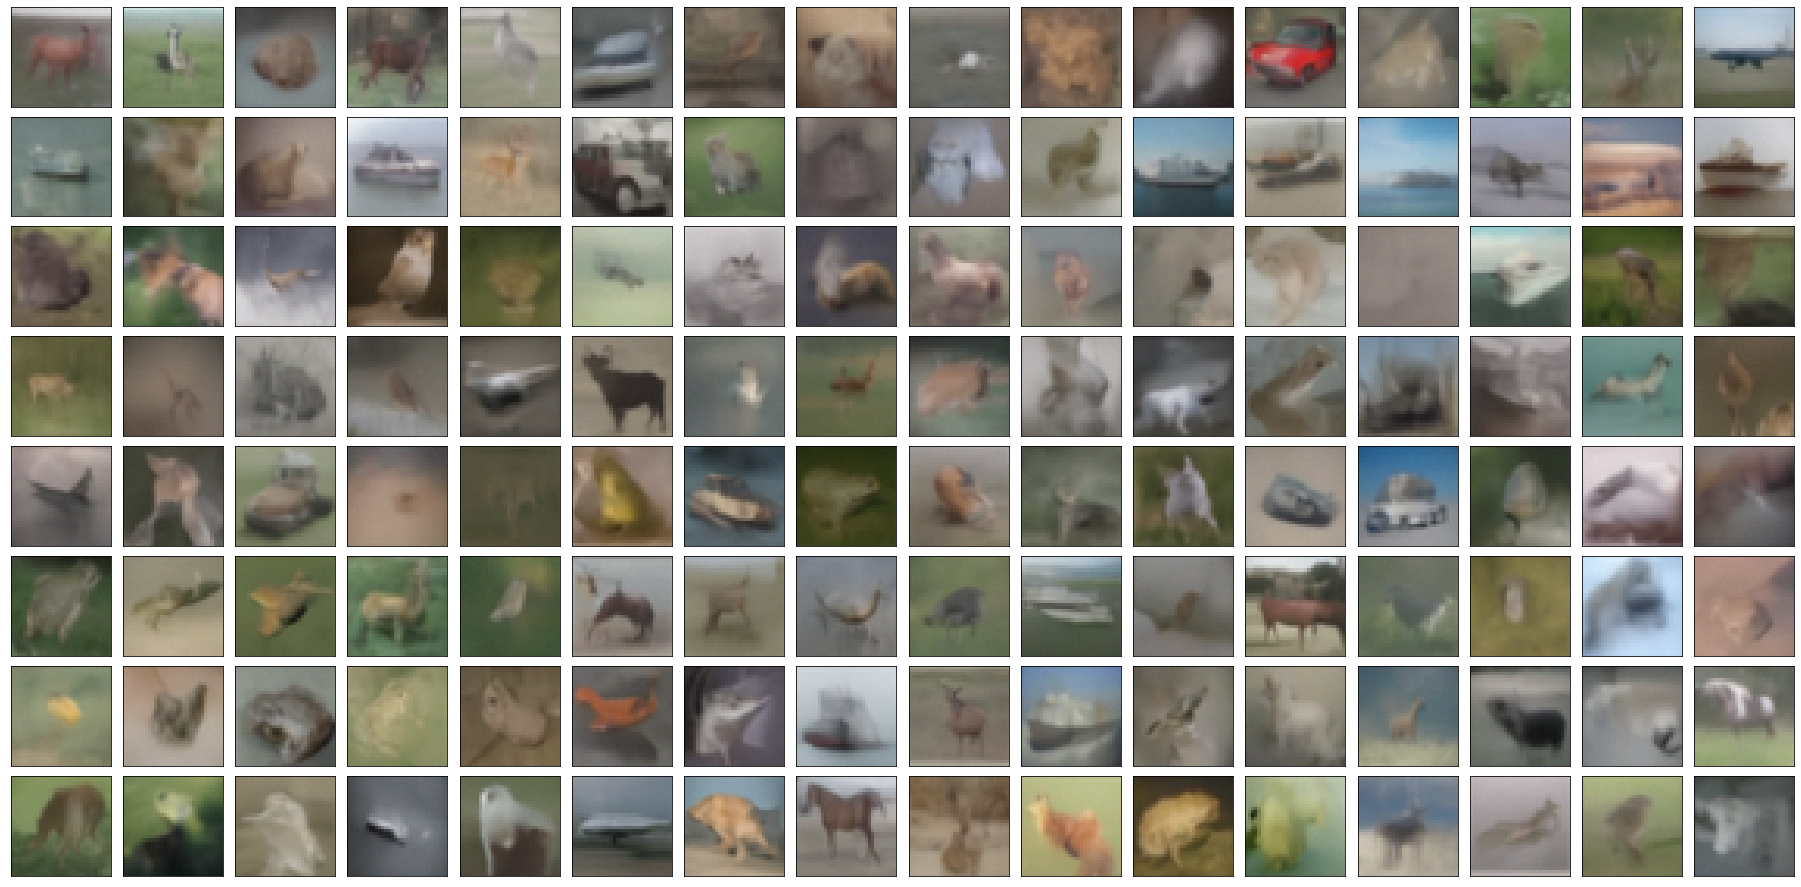

In [22]:
z = torch.randn(128, 3, 32, 32).to(args.device)
z = diffuser.reverse_process(z, ema_model, num_steps=10)

out = z.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

n = 0

for i in range(8 *  16):
    _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
    _fig.imshow(out[i])
    n += 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

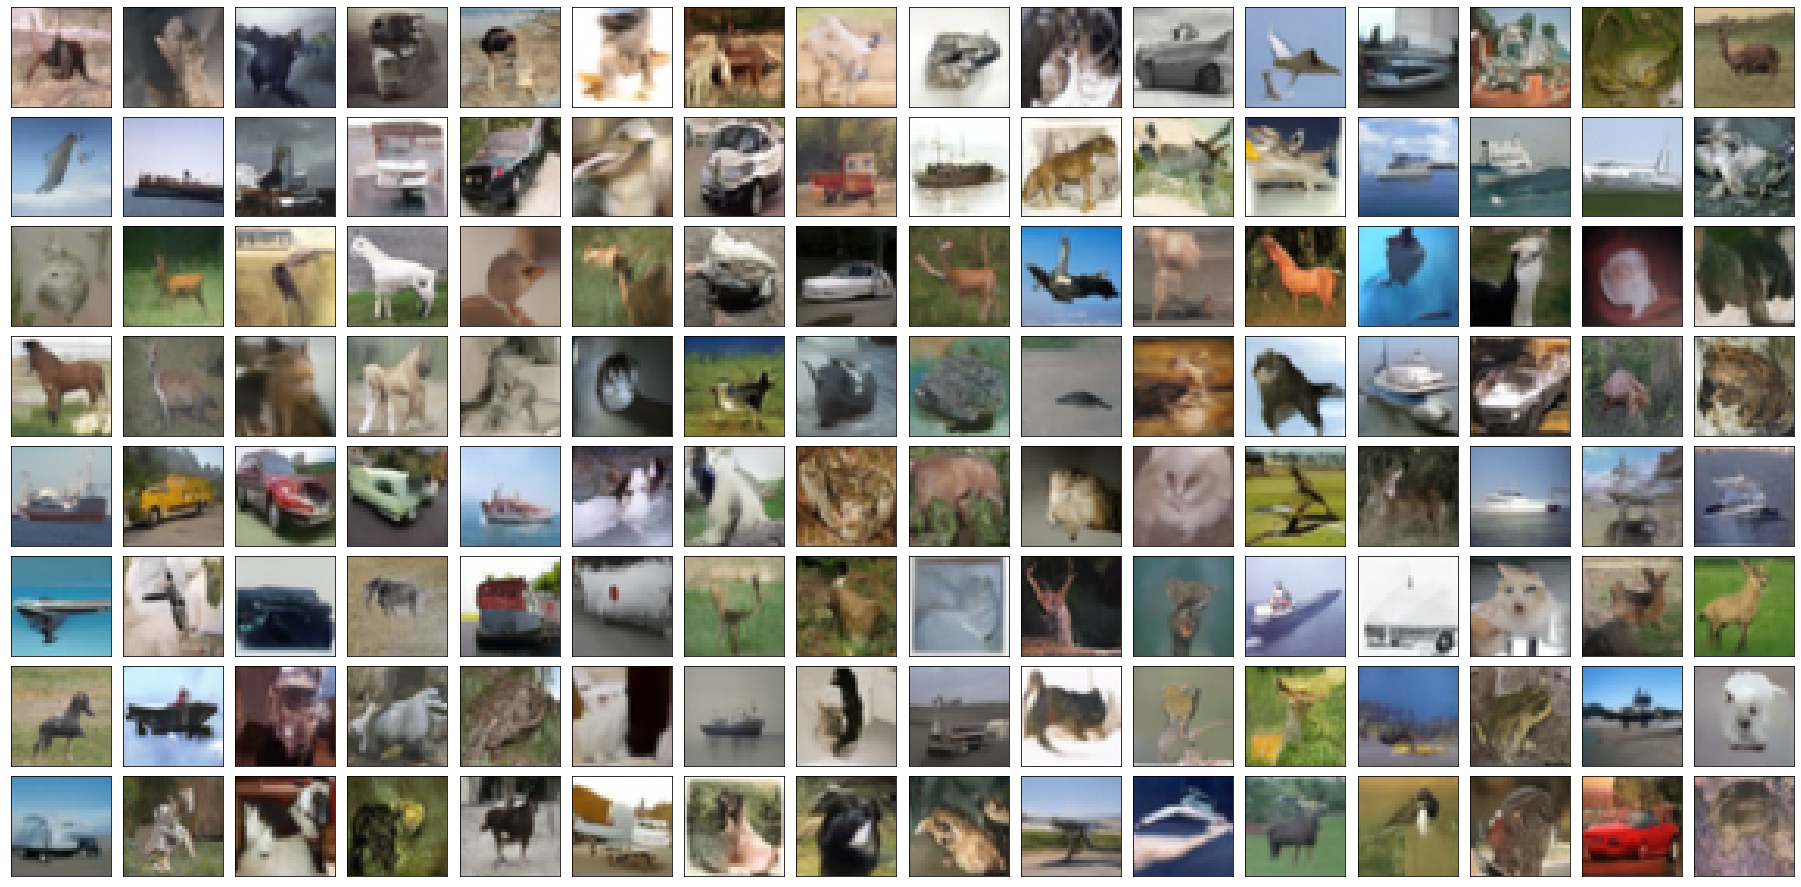

In [21]:
z = torch.randn(128, 3, 32, 32).to(args.device)
z = diffuser.reverse_process(z, ema_model, num_steps=50)

out = z.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

n = 0

for i in range(8 *  16):
    _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
    _fig.imshow(out[i])
    n += 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

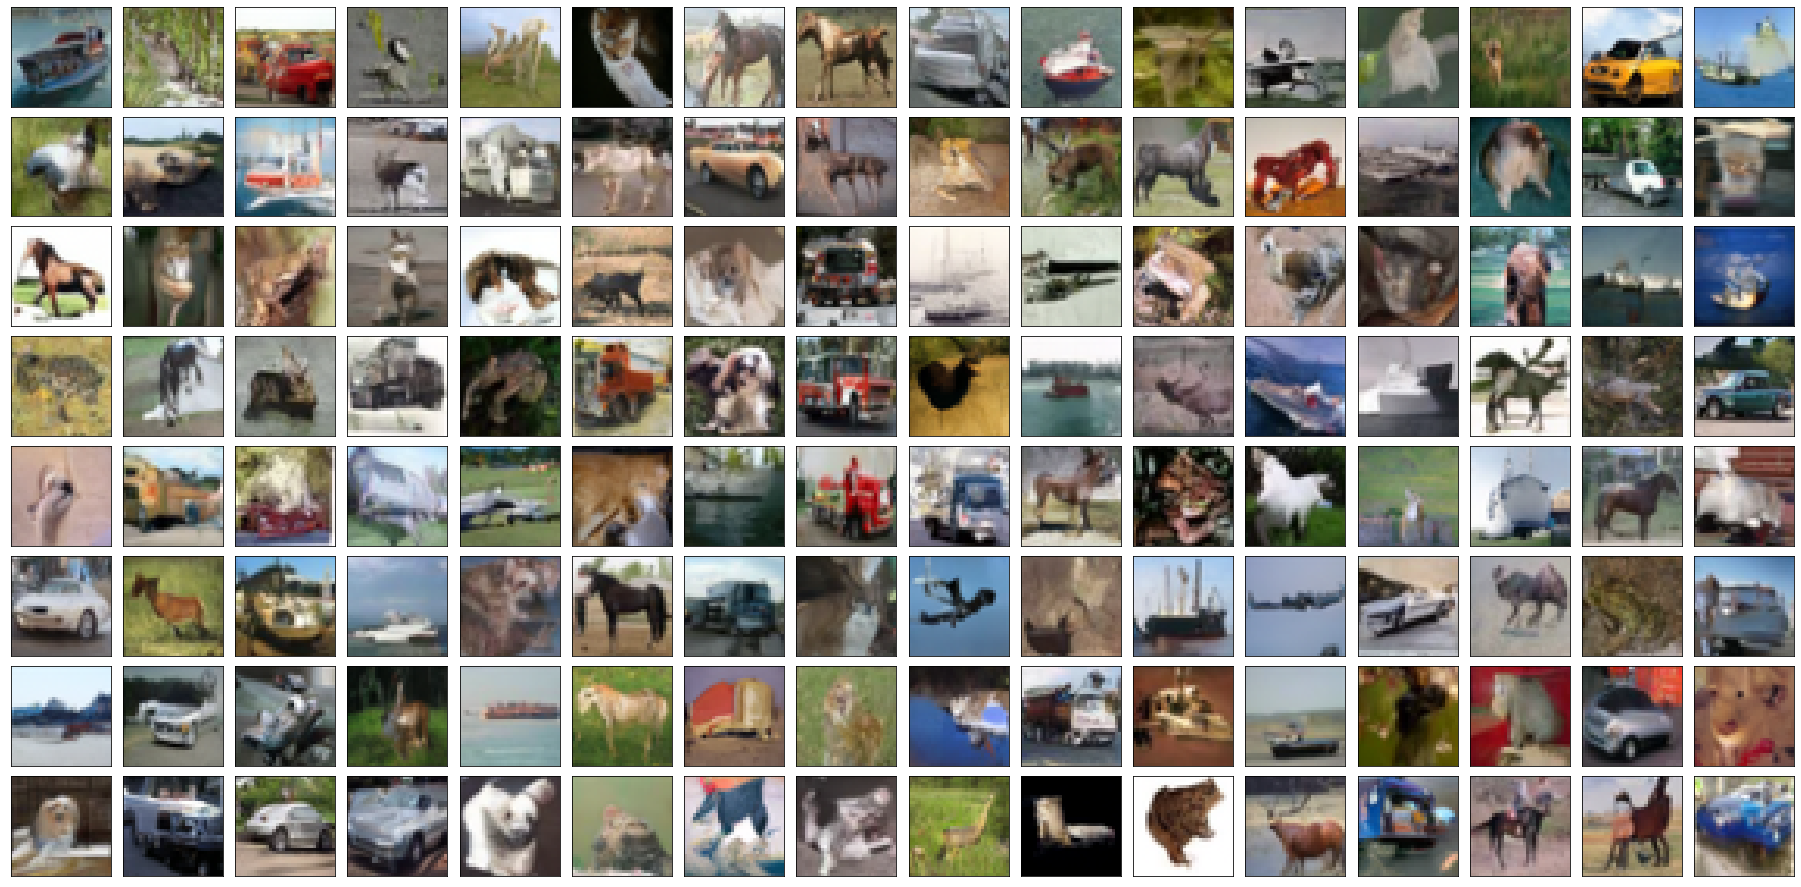

In [16]:
z = torch.randn(128, 3, 32, 32).to(args.device)
z = diffuser.reverse_process(z, ema_model, num_steps=200)

out = z.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

n = 0

for i in range(8 *  16):
    _fig = fig.add_subplot(8, 16, n + 1, xticks=[], yticks=[])
    _fig.imshow(out[i])
    n += 1

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

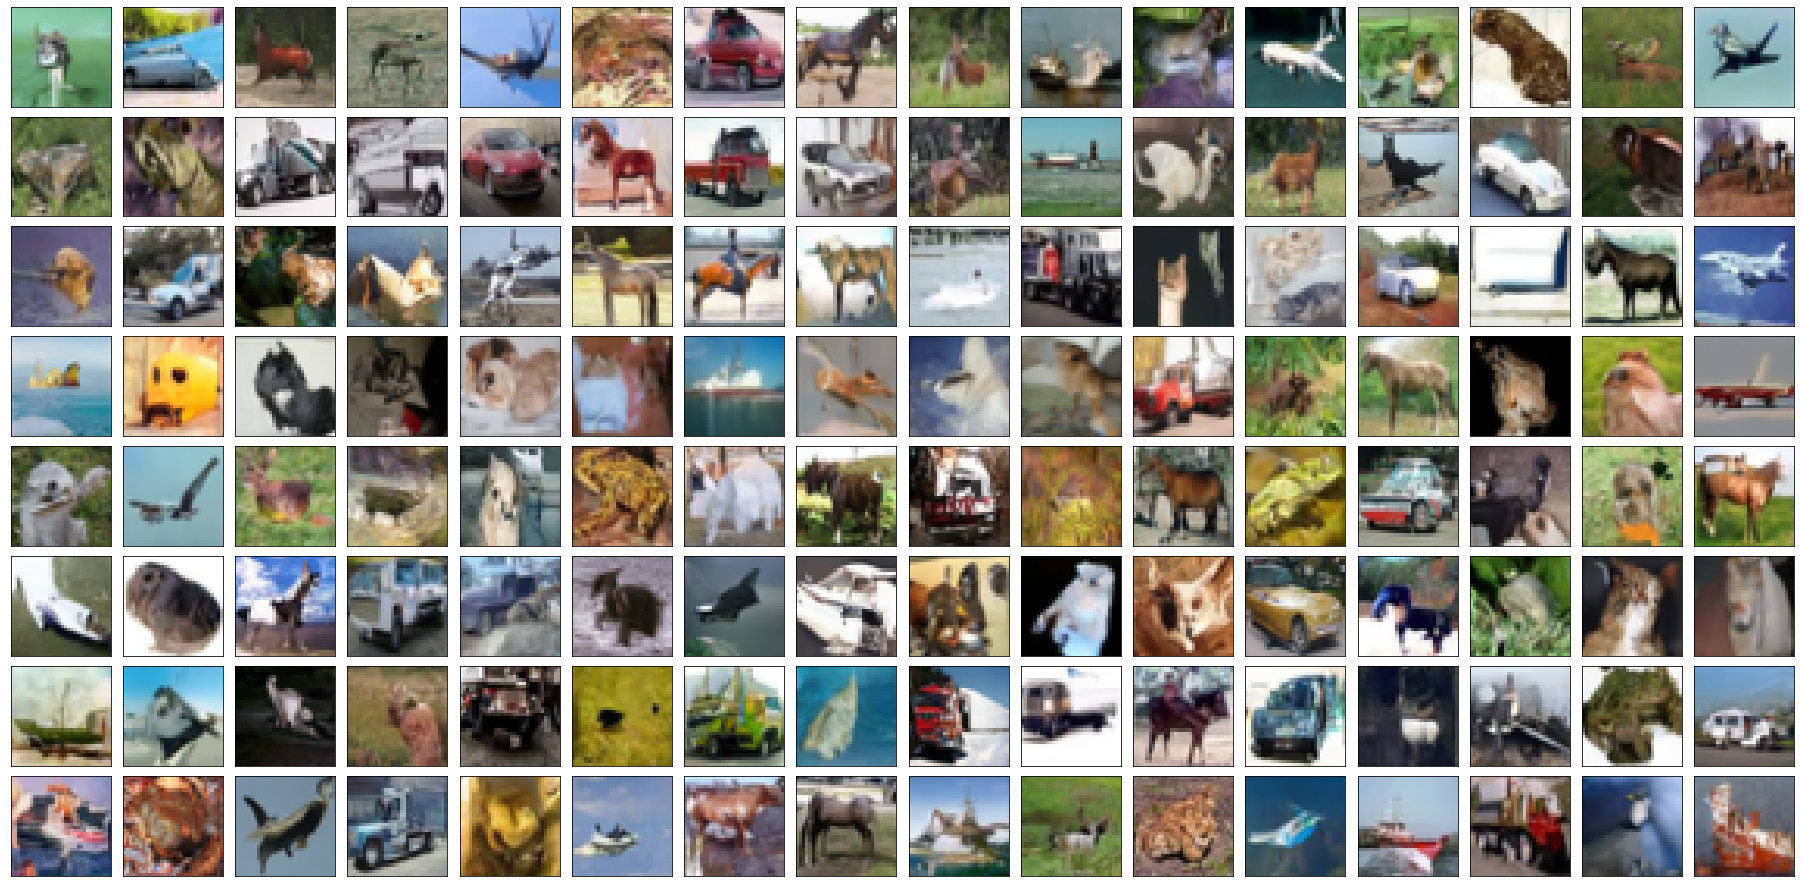

In [18]:
z = torch.randn(128, 3, 32, 32).to(args.device)
z = diffuser.reverse_process(z, ema_model, num_steps=1000)

out = z.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

for i in range(8 *  16):
    sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
    sub_fig.imshow(out[i])

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

In [17]:
torch.save({'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'ema_model': ema_model.state_dict()}, "/content/drive/My Drive/" + "vdm_cifar10.pth")

In [ ]:
# state_dict = torch.load("/content/drive/My Drive/" + "untitled303.pth")
# model.load_state_dict(state_dict['model'])
# optimizer.load_state_dict(state_dict['optimizer'])
# ema_model.load_state_dict(state_dict['ema_model'])

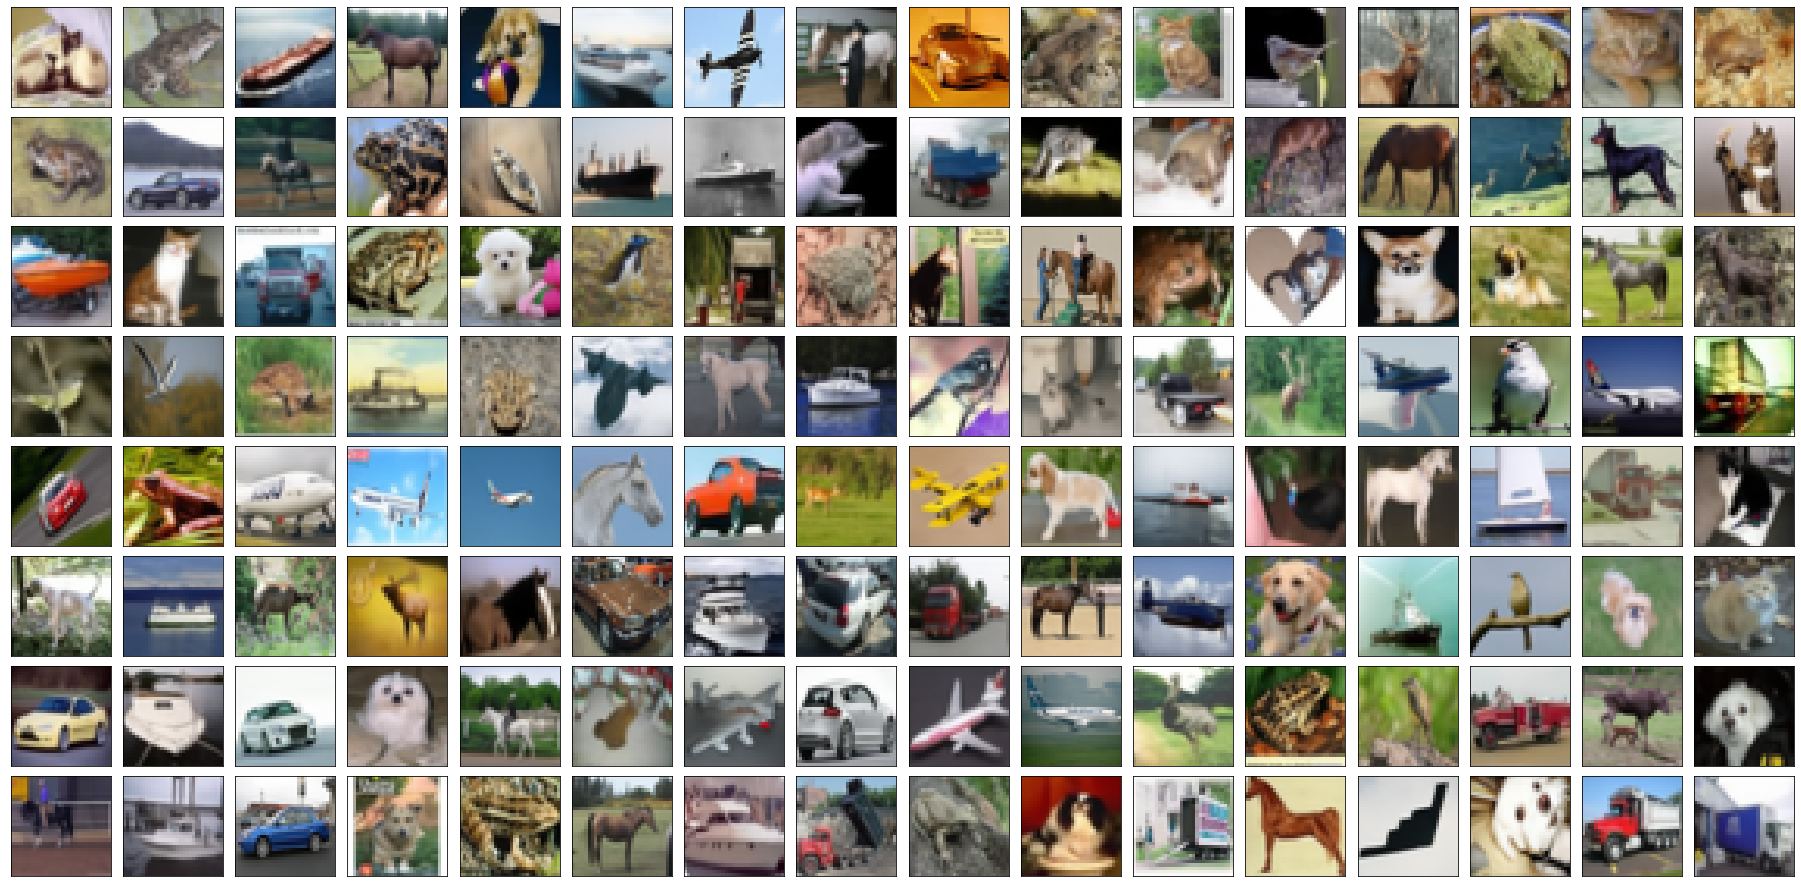

In [40]:
@torch.no_grad()
def reconstruct(x, model, diffuser, time=0.2):
    x = 2. * x - 1.
    x = x.to(args.device)
    t = torch.FloatTensor([time]).to(x.device)
    z, noise = diffuser.forward_process(x, t)
    noise_pred = model(z, t)
    alpha_t = get_signal_scale(diffuser.log_snr(t))
    sigma_t = get_noise_scale(diffuser.log_snr(t))
    x_pred = (z - sigma_t * noise_pred) / alpha_t
    return x_pred


x, _ = next(iter(DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=True)))
x_pred = reconstruct(x, ema_model, diffuser, time=0.2)
out = x_pred.clamp(-1, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
out = (out + 1.) * 0.5

fig = plt.figure(figsize=(32, 16))

for i in range(8 *  16):
    sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
    sub_fig.imshow(out[i])

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()